In [44]:
import numpy as np
import pandas as pd

import dtale
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [45]:
dataset = pd.read_csv('Bitfinex_BTCUST_1h.csv')

# # Assign new column names based on their index to handle hidden characters or mismatches:
# dataset.columns = [f'col{i}' for i in range(len(dataset.columns))]
#
# # Try to convert the 'date' column (now named 'col1') to datetime, use errors='coerce' to handle invalid formats
# dataset['col1'] = pd.to_datetime(dataset['col1'], errors='coerce')
#
# # Now printing out the head of the dataset to see the first few rows of the 'date' column (renamed to 'col1'):
# print(dataset['col1'].head())
#
# # Use D-Tale to show the DataFrame for a more interactive data analysis

X = dataset.iloc[:, :-1].values
Y = dataset.iloc[:, -1].values
dataset['price_change'] = dataset['close'].diff(-1)
# dtale.show(dataset)
dataset.to_csv('BTCUST_price_changes.csv', index=False)
# dtale.show(X)
# dtale.show(Y)


In [46]:
import tensorflow
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Load the dataset
df = pd.read_csv('Bitfinex_BTCUST_1h.csv')
# Assuming the file has a 'close' column which we are interested in
data = df.filter(['close'])

# Convert the 'close' column to a numpy array
dataset = data.values
training_data_len = math.ceil(len(dataset) * .8)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Create the scaled training data set
train_data = scaled_data[0:training_data_len, :]

# Split the data into x_train and y_train data sets
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data for the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

# Create the testing data set
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Calculate the RMSE
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))


81/81 [==============================] - 5s 28ms/step


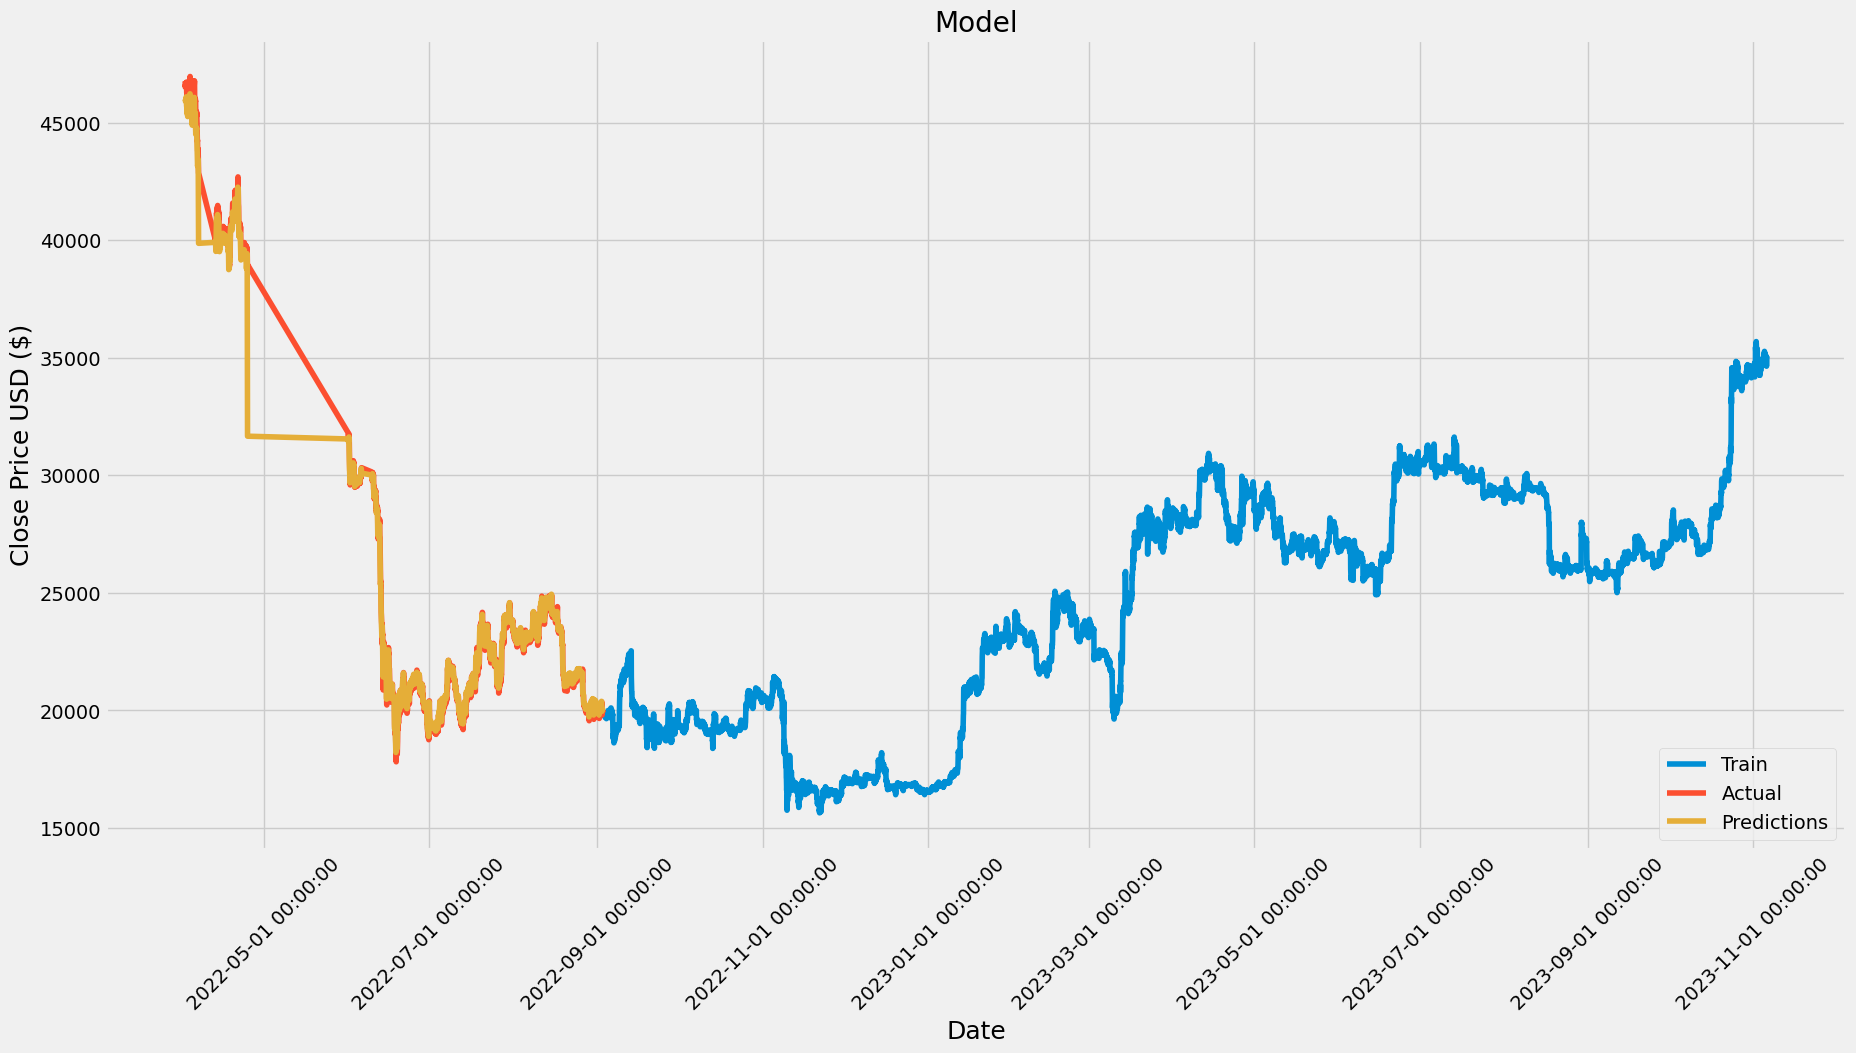

In [55]:
# Assuming 'df' is your DataFrame and the second column is named 'Date'

# Parse the 'Date' column into datetime
df['Date'] = pd.to_datetime(df['date'])

# Set 'Date' as the index of your DataFrame (optional but helpful)
df.set_index('Date', inplace=True)

# Now when you plot, you can directly use the DataFrame index
plt.figure(figsize=(20,10))  # Adjust the figure size as needed
plt.plot(df.index[:training_data_len], df['close'][:training_data_len], label='Train')
plt.plot(df.index[training_data_len:], df['close'][training_data_len:], label='Actual')
plt.plot(df.index[training_data_len:], predictions, label='Predictions')
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend(loc='lower right')

# Format x-axis to show dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

# Optionally, you could also rotate the dates for better readability
plt.xticks(rotation=45)

# Save the plot with a higher resolution
plt.savefig('BTC_price_prediction.png', dpi=300)

# Show plot
plt.show()
